** Uploading Data in zipfile**

In [1]:
import zipfile
import os

# Path of uploaded file
zip_path = "/content/dataset.zip"

# Unzip to a folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("unzipped_data")   # creates a folder "unzipped_data"

# List extracted files
os.listdir("unzipped_data")

['dataset', '__MACOSX']

**Importing necessary Python library**

In [26]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models

**set up the device**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Data Augmentation and loading the data **

In [4]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset_path = '/content/unzipped_data/dataset'
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)

len(dataset)

2300

In [28]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75*len(dataset))
test_size = len(dataset) - train_size

train_size, test_size

(1725, 575)

In [8]:
from torch.utils.data import random_split

train_data, val_data = random_split(dataset, [train_size, test_size])

train_data, val_data

(<torch.utils.data.dataset.Subset at 0x79d313d5d6a0>,
 <torch.utils.data.dataset.Subset at 0x79d222e890d0>)

In [9]:
train_datao = DataLoader(train_data, batch_size=32, shuffle=True)
val_datao = DataLoader(val_data, batch_size=32, shuffle=True)

In [10]:
for images, labels in train_datao:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
labels[0]

tensor(4)

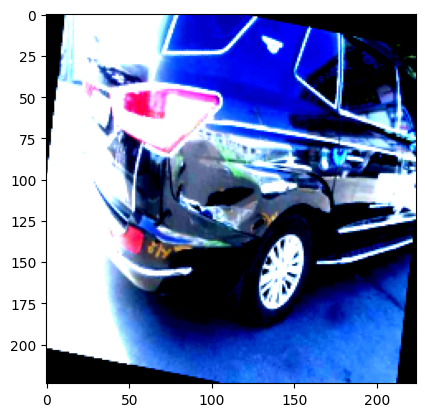

In [12]:
from matplotlib import pyplot as plt

plt.imshow(images[0].permute(1, 2, 0))
plt.show()

Model 1 :**CNN**

In [13]:
class CarClassifierCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, padding=0),
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2,padding=0),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2,padding=0),
        nn.Flatten(),
        nn.Linear(64*28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 6)
    )
  def forward(self, x):
    x = self.network(x)
    return x


In [14]:
model = CarClassifierCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [15]:
def train_model(model, loss_fn, optimizer, epochs=5):
  start_time = time.time()

  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_datao):
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = model(images)
      loss = loss_fn(outputs, labels)

      loss.backward()
      optimizer.step()

      if (i+1) % 20 == 0:
        print(f"batch {i+1}, epoch: {epoch+1}, Loss: {loss.item():0.2f}")

      running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_datao.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")


    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for images, labels in val_datao:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    end = time.time()
    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy*100:.2f}%")
  return all_labels, all_preds

In [42]:
train_model(model, loss_fn, optimizer, epochs=5)

KeyboardInterrupt: 

** Model 2 using Regularization **

In [20]:
class CarClassifierCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, padding=0),
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2,padding=0),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2,padding=0),
        nn.Flatten(),
        nn.Linear(64*28*28, 512),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(512, 6)
    )
  def forward(self, x):
    x = self.network(x)
    return x

In [21]:
model = CarClassifierCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [23]:
train_model(model, loss_fn, optimizer, epochs=3)

batch 20, epoch: 1, Loss: 3.11
batch 40, epoch: 1, Loss: 2.02
Epoch [1/3], Loss: 5.9659
Validation Accuracy: 45.57%
batch 20, epoch: 2, Loss: 1.22
batch 40, epoch: 2, Loss: 1.13
Epoch [2/3], Loss: 1.3328
Validation Accuracy: 50.96%
batch 20, epoch: 3, Loss: 1.14
batch 40, epoch: 3, Loss: 1.24
Epoch [3/3], Loss: 1.1791
Validation Accuracy: 52.17%


**MODEL : 3 "efficientnet_b0"**

In [43]:
class CarClassifierCNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.model = models.efficientnet_b0(weights="DEFAULT")
    for param in self.model.parameters():
      param.requires_grad = False
    in_features = self.model.classifier[1].in_features
    self.model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features, num_classes)
    )
  def forward(self, x):
    x = self.model(x)
    return x


In [44]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [45]:
train_model(model, loss_fn, optimizer, epochs=10)

batch 20, epoch: 1, Loss: 1.62
batch 40, epoch: 1, Loss: 1.38
Epoch [1/10], Loss: 1.5035
Validation Accuracy: 58.61%
batch 20, epoch: 2, Loss: 1.24
batch 40, epoch: 2, Loss: 1.21
Epoch [2/10], Loss: 1.1448
Validation Accuracy: 64.00%
batch 20, epoch: 3, Loss: 0.93
batch 40, epoch: 3, Loss: 0.99
Epoch [3/10], Loss: 1.0259
Validation Accuracy: 65.39%
batch 20, epoch: 4, Loss: 1.00
batch 40, epoch: 4, Loss: 0.91
Epoch [4/10], Loss: 0.9563
Validation Accuracy: 64.00%
batch 20, epoch: 5, Loss: 0.68
batch 40, epoch: 5, Loss: 0.91
Epoch [5/10], Loss: 0.8981
Validation Accuracy: 64.70%
batch 20, epoch: 6, Loss: 1.03
batch 40, epoch: 6, Loss: 1.03
Epoch [6/10], Loss: 0.8788
Validation Accuracy: 68.70%
batch 20, epoch: 7, Loss: 0.79
batch 40, epoch: 7, Loss: 0.96
Epoch [7/10], Loss: 0.8591
Validation Accuracy: 68.87%
batch 20, epoch: 8, Loss: 0.74
batch 40, epoch: 8, Loss: 0.89
Epoch [8/10], Loss: 0.8426
Validation Accuracy: 68.00%
batch 20, epoch: 9, Loss: 0.67
batch 40, epoch: 9, Loss: 0.74
Ep

**Model :4 using "Resnet"**

In [16]:
class CarClassifierResnet(nn.Module):
  def __init__(self, num_classes, dropout_rate = 0.5):
    super().__init__()
    self.model = models.resnet50(weights="DEFAULT")

    for param in self.model.parameters():
      param.requires_grad = False

    for param in self.model.layer4.parameters():
      param.requires_grad = True

    #in_features = self.model.classifier[1].in_features
    self.model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(self.model.fc.in_features, num_classes)
    )
  def forward(self, x):
    x = self.model(x)
    return x


In [52]:
model = CarClassifierResnet(num_classes=num_classes).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


In [54]:
labels, predictions = train_model(model, loss_fn, optimizer, epochs=5)

batch 20, epoch: 1, Loss: 0.16
batch 40, epoch: 1, Loss: 0.07
Epoch [1/5], Loss: 0.0866
Validation Accuracy: 78.43%
batch 20, epoch: 2, Loss: 0.04
batch 40, epoch: 2, Loss: 0.12
Epoch [2/5], Loss: 0.0663
Validation Accuracy: 80.70%
batch 20, epoch: 3, Loss: 0.02
batch 40, epoch: 3, Loss: 0.05
Epoch [3/5], Loss: 0.0471
Validation Accuracy: 79.83%
batch 20, epoch: 4, Loss: 0.15
batch 40, epoch: 4, Loss: 0.04
Epoch [4/5], Loss: 0.0798
Validation Accuracy: 77.57%
batch 20, epoch: 5, Loss: 0.04
batch 40, epoch: 5, Loss: 0.10
Epoch [5/5], Loss: 0.0586
Validation Accuracy: 81.57%


TypeError: cannot unpack non-iterable NoneType object

In [60]:
labels, predictions = train_model(model, loss_fn, optimizer, epochs=3)
print(labels[:5], predictions[:5])

batch 20, epoch: 1, Loss: 0.02
batch 40, epoch: 1, Loss: 0.01
Epoch [1/3], Loss: 0.0457
Validation Accuracy: 79.48%
batch 20, epoch: 2, Loss: 0.06
batch 40, epoch: 2, Loss: 0.15
Epoch [2/3], Loss: 0.0590
Validation Accuracy: 80.87%
batch 20, epoch: 3, Loss: 0.01
batch 40, epoch: 3, Loss: 0.02
Epoch [3/3], Loss: 0.0361
Validation Accuracy: 80.35%
[np.int64(5), np.int64(4), np.int64(2), np.int64(2), np.int64(3)] [np.int64(5), np.int64(4), np.int64(2), np.int64(2), np.int64(3)]


In [61]:
labels[:5], predictions[:5]

([np.int64(5), np.int64(4), np.int64(2), np.int64(2), np.int64(3)],
 [np.int64(5), np.int64(4), np.int64(2), np.int64(2), np.int64(3)])

In [62]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       123
           1       0.77      0.73      0.75        92
           2       0.93      0.91      0.92       137
           3       0.64      0.94      0.76        67
           4       0.75      0.49      0.59        83
           5       0.84      0.77      0.80        73

    accuracy                           0.80       575
   macro avg       0.79      0.79      0.78       575
weighted avg       0.81      0.80      0.80       575



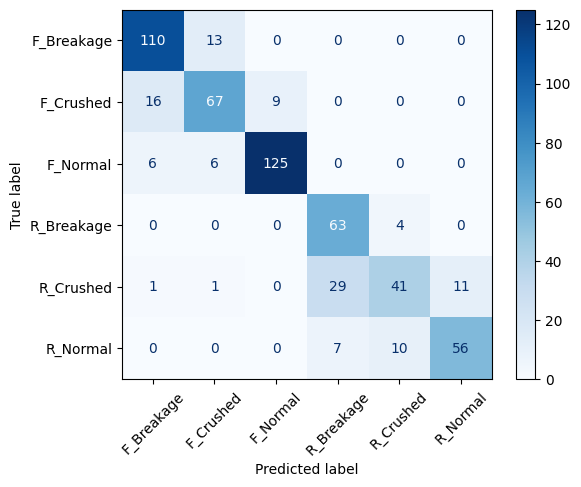

In [65]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_max = confusion_matrix(labels, predictions, labels=np.arange(6))
dis = ConfusionMatrixDisplay(confusion_matrix=conf_max, display_labels=dataset.classes)
dis.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()



In [68]:
torch.save(model.state_dict(), "model.pth")


In [69]:
from google.colab import files
files.download("model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model 5 with best hyperparameters**

In [17]:
class CarClassifierResnet(nn.Module):
  def __init__(self, num_classes, dropout_rate = 0.5):
    super().__init__()
    self.model = models.resnet50(weights="DEFAULT")

    for param in self.model.parameters():
      param.requires_grad = False

    for param in self.model.layer4.parameters():
      param.requires_grad = True

    #in_features = self.model.classifier[1].in_features
    self.model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(self.model.fc.in_features, num_classes)
    )
  def forward(self, x):
    x = self.model(x)
    return x


In [18]:
model = CarClassifierResnet(num_classes=num_classes, dropout_rate = 0.2).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


In [20]:
labels, predictions = train_model(model, loss_fn, optimizer, epochs=5)
print(labels[:5], predictions[:5])

batch 20, epoch: 1, Loss: 0.27
batch 40, epoch: 1, Loss: 0.36
Epoch [1/5], Loss: 0.2656
Validation Accuracy: 76.70%
batch 20, epoch: 2, Loss: 0.18
batch 40, epoch: 2, Loss: 0.26
Epoch [2/5], Loss: 0.1515
Validation Accuracy: 77.57%
batch 20, epoch: 3, Loss: 0.04
batch 40, epoch: 3, Loss: 0.05
Epoch [3/5], Loss: 0.1222
Validation Accuracy: 77.91%
batch 20, epoch: 4, Loss: 0.10
batch 40, epoch: 4, Loss: 0.15
Epoch [4/5], Loss: 0.1013
Validation Accuracy: 80.52%
batch 20, epoch: 5, Loss: 0.02
batch 40, epoch: 5, Loss: 0.03
Epoch [5/5], Loss: 0.0827
Validation Accuracy: 81.57%
[np.int64(1), np.int64(1), np.int64(2), np.int64(0), np.int64(2)] [np.int64(1), np.int64(2), np.int64(2), np.int64(0), np.int64(2)]


In [22]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       124
           1       0.76      0.83      0.79       110
           2       0.95      0.91      0.93       133
           3       0.87      0.69      0.77        67
           4       0.63      0.80      0.71        69
           5       0.82      0.74      0.77        72

    accuracy                           0.82       575
   macro avg       0.81      0.80      0.80       575
weighted avg       0.82      0.82      0.82       575



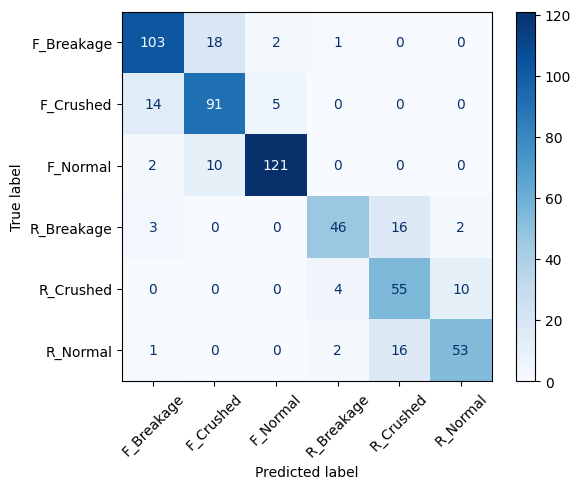

In [23]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_max = confusion_matrix(labels, predictions, labels=np.arange(6))
dis = ConfusionMatrixDisplay(confusion_matrix=conf_max, display_labels=dataset.classes)
dis.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()


In [24]:
torch.save(model.state_dict(), "../training/model1.pth")


In [25]:
from google.colab import files
files.download("model1.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>